# Basic time series analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import scipy as sp
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

In [2]:
curr_code = ['AUD', 'EUR', 'NZD', 'GBP', 'BRL',
            'CAD', 'CNY', 'HKD', 'INR', 'KRW',
            'MXN', 'ZAR', 'SGD', 'DKK', 'JPY',
            'MYR', 'NOK', 'SEK', 'LKR', 'CHF',
            'TWD', 'THB']

# FX rates

In [3]:
## Read in data
fx = pd.read_csv("FX_rates.csv", usecols = list(range(1,24)))

## Convert dates into date format
fx['Time Serie'] = pd.to_datetime(fx['Time Serie'], format = '%Y-%m-%d')

## Replace missing data with NaN
fx = fx.replace('ND', np.nan)

## Create clean dataset with no missing data
fx = fx.dropna().copy()

## Convert string numbers into floats
fx.iloc[:,1:23] = fx.iloc[:,1:23].apply(pd.to_numeric)

#Change column names for convenience
fx.columns = ['Date'] + curr_code

# USD/GBP rates

In [4]:
#Daily UK exchange rates, Jan 2005 to Jan 2009 inclusive
fx_uk = fx.iloc[range(1257, 2282), [0, 4]]

#Monthly average UK exchange rates, Jan 2005 to Jan 2009 inclusive
fx_uk = fx_uk.set_index('Date')
fx_uk = fx_uk.resample('M').mean()

# Interest rates
The use of short-term interest rate data is motivated by two factors:

a) sources have mentioned that the unwinding of carry trades may be able to explain exchange rate movements during the global financial crisis, and

b) <b>monthly</b> data is available for it at https://data.oecd.org/interest/short-term-interest-rates.htm.

# UK short-term interest rates 

In [5]:
#Monthly real short-term interest rates, Jan 2005 to Jan 2009 inclusive
ir_uk = pd.read_csv("UK_STrates.csv", usecols = [5,6])
ir_uk = ir_uk.iloc[range(0, 49), :]

#Convert dates into pd.Datetime object 
ir_uk['TIME'] = pd.to_datetime(ir_uk['TIME'], format = '%Y-%m-%d')

# Stationarity
We want the data to be stationary; in the regression context the stationarity is important since the same results which apply for independent data holds if the data is stationary. 

The mean and variance of a stationary time series are constant over time. Here is a comparison between a stationary and non-stationary series:
<img src=https://upload.wikimedia.org/wikipedia/commons/e/e1/Stationarycomparison.png>
Image source: https://upload.wikimedia.org/wikipedia/commons/e/e1/Stationarycomparison.png

# Spurious correlation

A variable with a time trend is highly likely to be correlated with another variable that has a time trend. For example, a person A's weight from birth to age 20 is going to be highly correlated with person B's weight from birth to age 20. This is true for the vast majority of any two people randomly selected from the global population. But obviously, person A's weight does not 'cause' and is not 'caused by' person B's weight.

Making a series stationary helps to reduce the possibility of detecting such a spurious correlation.

# Making a time series stationary
Two common ways of achieving this are: 

1) Taking the logarithm of the series and 

2) taking the first difference of the series (difference of consecutive values). 

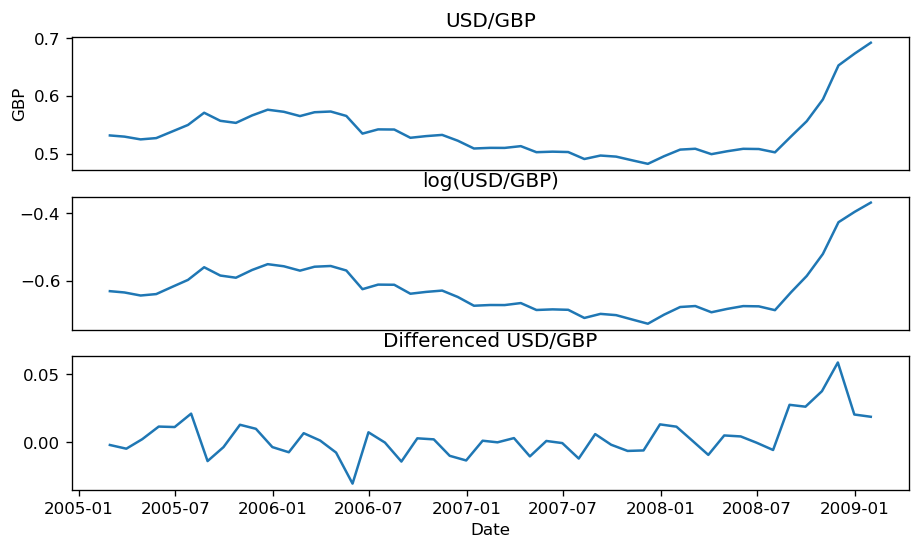

In [6]:
#plt.subplot(x, y, z) means a plot with 3 rows, 1 column, where z is the row number of the subplot
plt.subplot(3, 1, 1)
plt.plot(fx_uk.index, fx_uk['GBP'])
plt.ylabel('GBP')
#Removes xticks to improve readability
plt.xticks([])
plt.title('USD/GBP')

plt.subplot(3, 1, 2)
plt.plot(fx_uk.index, np.log(fx_uk['GBP']))
#Removes xticks, since the bottom subplot has xticks
plt.xticks([])
plt.title('log(USD/GBP)')

plt.subplot(3, 1, 3)
plt.plot(fx_uk.index, fx_uk['GBP'].diff())
plt.xlabel('Date')
plt.title('Differenced USD/GBP')

plt.show()

Differencing makes the series noticeably more stationary. There are more quantitative methods to measure this, which is a possible extension. Arguably, the mean and/or variance increase towards the end of the period, so it may be worth restricting the period considered. 

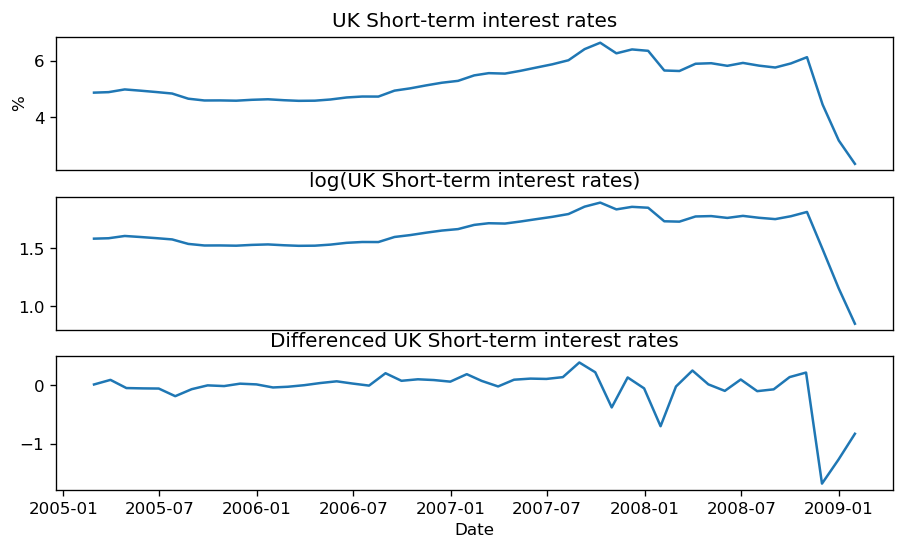

In [7]:
#plt.subplot(x, y, z) means a plot with 3 rows, 1 column, where z is the row number of the subplot
plt.subplot(3, 1, 1)
plt.plot(fx_uk.index, ir_uk['Value'])
plt.ylabel('%')
#Removes xticks to improve readability. The bottom subplot still has xticks
plt.xticks([])
plt.title('UK Short-term interest rates')

plt.subplot(3, 1, 2)
plt.plot(fx_uk.index, np.log(ir_uk['Value']))
plt.xticks([])
plt.title('log(UK Short-term interest rates)')

plt.subplot(3, 1, 3)
plt.plot(fx_uk.index, ir_uk['Value'].diff())
plt.xlabel('Date')
plt.title('Differenced UK Short-term interest rates')

plt.show()

Differencing appears to make the series more stationary, but this is less obvious than before. Here, we can say with more confidence that the mean decreases and the variance increases towards the end of the period, so an extension would be to restrict the period considered, perhaps from 2004-2007, since this would be entirely pre-crisis. 

# Pearson correlation coefficient

In [19]:
print ("Pearson correlation coefficient and p-value: ",
       sp.stats.pearsonr(fx_uk['GBP'].diff()[1:], ir_uk['Value'].diff()[1:]))

Pearson correlation coefficient and p-value:  (-0.5626616026874436, 3.1468586319065237e-05)


The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a similar correlation coefficient. 
Note that the accuracy of the p-value is reduced by the fact that our vectors only have 49 data points each. This is a consequence of having only monthly data, and the fact that it is only a short pre-crisis period we are interested in. 

# Linear Regression
This small p-value suggests that there may be a causal relationship to be found between the variables, as we hypothesised. We can fit a regression model to test aspects of this. 

In [9]:
#Hypothesised explanatory variable; differenced interest rate
#Reshaped since this is the format expected by the model
x = np.array(ir_uk['Value'].diff()[1:])
x_reshaped = np.array(ir_uk['Value'].diff()[1:]).reshape((-1, 1))

#Hypothesised response variable; differenced exchange rate
y = np.array(fx_uk['GBP'].diff()[1:])

model = LinearRegression().fit(x_reshaped, y)

In [10]:
print ("R**2: ", model.score(x_reshaped, y))

R**2:  0.31658807913880294


Around 30% of the variation in the USD/GBP exchange rate can be explained by UK short-term interest rates according to this model. 

# Residual plot
One way to quickly assess the adequacy of a linear model is by plotting the residuals, i.e. the difference between the actual and predicted y-values:

Text(0.5, 1.0, 'Residuals, UK model')

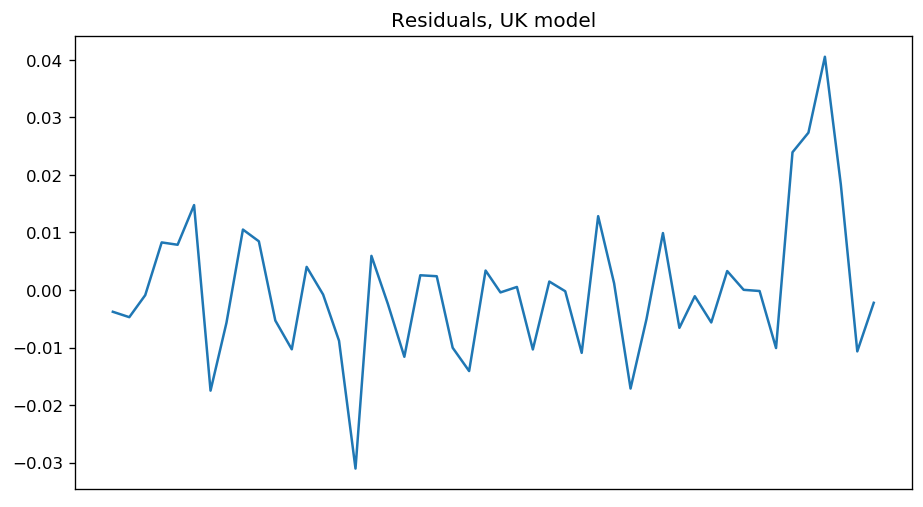

In [11]:
plt.plot(fx_uk['GBP'].diff()[1:] - model.predict(x_reshaped))
plt.xticks([])
plt.title('Residuals, UK model')

There is no clear pattern among the residuals, which suggests that the model is not inadequate. 

# Granger causality test
This is used to determine if one time series will be useful to forecast another.

If x causes y, the forecast of y based on previous values of y and previous values of x should outperform the forecast of y based on previous values of y alone.

Null hypothesis: The series in the second column does not Granger cause the series in the first. 

In [12]:
inp = pd.DataFrame({'x': x, 'y': y})
grangercausalitytests(inp, maxlag=2)
#maxlag specifies how much to lag x and y by 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.8465 , p=0.0004  , df_denom=44, df_num=1
ssr based chi2 test:   chi2=15.8588 , p=0.0001  , df=1
likelihood ratio test: chi2=13.6649 , p=0.0002  , df=1
parameter F test:         F=14.8465 , p=0.0004  , df_denom=44, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.4589  , p=0.0004  , df_denom=41, df_num=2
ssr based chi2 test:   chi2=21.2248 , p=0.0000  , df=2
likelihood ratio test: chi2=17.4525 , p=0.0002  , df=2
parameter F test:         F=9.4589  , p=0.0004  , df_denom=41, df_num=2


{1: ({'ssr_ftest': (14.846515667692918, 0.0003752297812108861, 44.0, 1),
   'ssr_chi2test': (15.858778099581071, 6.82492151059198e-05, 1),
   'lrtest': (13.664920578370172, 0.00021849818112427115, 1),
   'params_ftest': (14.846515667692916, 0.0003752297812108874, 44.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.458896197844195, 0.00041896243307393353, 41.0, 2),
   'ssr_chi2test': (21.22484024882112, 2.4608463624759036e-05, 2),
   'lrtest': (17.452465747679867, 0.00016227260763054552, 2),
   'params_ftest': (9.4588961978442, 0.0004189624330739322, 41.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

Looking at the p-values, the results are significant to a level below 0.01%.

# Repeating for USD/JPY and Japan short-term interest rates

In [13]:
#Daily USD/JPY exchange rate, Jan 2005 to Jan 2009 inclusive
fx_jpn = fx.iloc[range(1257, 2282), [0, 15]]

#Monthly average USD/JPY exchange rate, Jan 2005 to Jan 2009 inclusive
fx_jpn = fx_jpn.set_index('Date')
fx_jpn = fx_jpn.resample('M').mean()

#Monthly real short-term interest rates, Jan 2005 to Jan 2009 inclusive
ir_jpn = pd.read_csv("JPN_STrates.csv", usecols = [5,6])
ir_jpn = ir_jpn.iloc[range(0, 49), :]

#Convert dates into pd.Datetime object 
ir_jpn['TIME'] = pd.to_datetime(ir_jpn['TIME'], format = '%Y-%m-%d')

print ('Pearson correlation coefficient and p-value: ', 
       sp.stats.pearsonr(fx_jpn['JPY'].diff()[1:], ir_jpn['Value'].diff()[1:])) 

Pearson correlation coefficient and p-value:  (0.04405162290190073, 0.7662390191136452)


Results are very different for the Japanese Yen! But this does not cause us to reject our hypothesis, since it is a 'safe-haven' currency. 

In [14]:
#Hypothesised explanatory variable; differenced interest rate
#Reshaped since this is the format expected by the model
x_ = np.array(ir_jpn['Value'].diff()[1:])
x_reshaped_ = np.array(ir_jpn['Value'].diff()[1:]).reshape((-1, 1))

#Hypothesised response variable; differenced exchange rate
y_ = np.array(fx_jpn['JPY'].diff()[1:])

model = LinearRegression().fit(x_reshaped_, y_)

#R**2 score 
print ("R**2: ", model.score(x_reshaped_, y_))

R**2:  0.0019405454802911004


Text(0.5, 1.0, 'Residuals')

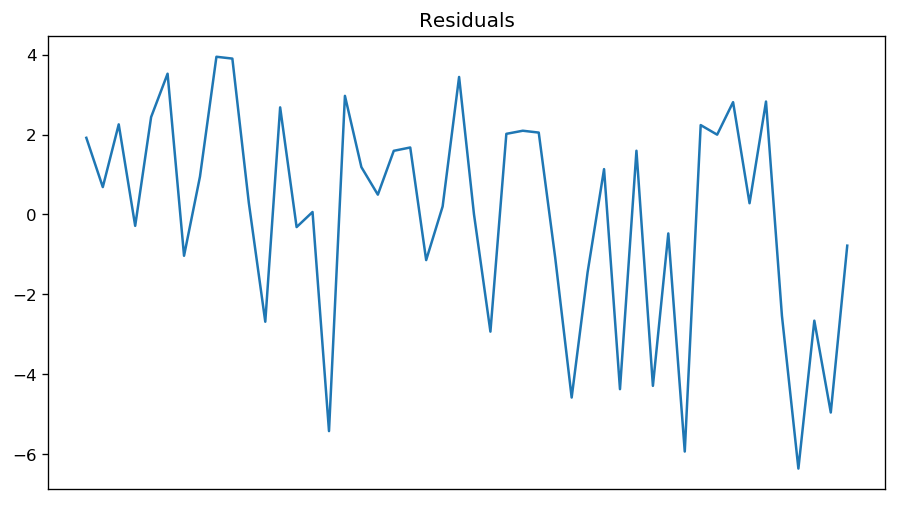

In [15]:
plt.plot(fx_jpn['JPY'].diff()[1:] - model.predict(x_reshaped_))
plt.xticks([])
plt.title('Residuals')

In [16]:
inp_ = pd.DataFrame({'x': x_, 'y': y_})
grangercausalitytests(inp_, maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2577  , p=0.1401  , df_denom=44, df_num=1
ssr based chi2 test:   chi2=2.4116  , p=0.1204  , df=1
likelihood ratio test: chi2=2.3518  , p=0.1251  , df=1
parameter F test:         F=2.2577  , p=0.1401  , df_denom=44, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8018  , p=0.1778  , df_denom=41, df_num=2
ssr based chi2 test:   chi2=4.0430  , p=0.1325  , df=2
likelihood ratio test: chi2=3.8751  , p=0.1441  , df=2
parameter F test:         F=1.8018  , p=0.1778  , df_denom=41, df_num=2


{1: ({'ssr_ftest': (2.257679962634366, 0.14009682241702498, 44.0, 1),
   'ssr_chi2test': (2.4116126873594363, 0.1204382353891249, 1),
   'lrtest': (2.3517798665473038, 0.12514005476164972, 1),
   'params_ftest': (2.2576799626343593, 0.14009682241702537, 44.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.8017834952390073, 0.17782484802100998, 41.0, 2),
   'ssr_chi2test': (4.043026379560699, 0.13245488398296143, 2),
   'lrtest': (3.8751212584788277, 0.14405492489615154, 2),
   'params_ftest': (1.8017834952390008, 0.17782484802101087, 41.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

# Bibliography
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary

https://stats.stackexchange.com/questions/7975/what-to-make-of-explanatories-in-time-series/8037#8037

https://realpython.com/linear-regression-in-python/